# Anomaly Model Training and Evaluation

Train IsolationForest on windowed DNS activity from simulation.

In [1]:
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sentineldns.data.simulations import write_simulation_jsonl
from sentineldns.features.window_features import aggregate_events_to_windows
from sentineldns.models.anomaly import train_anomaly_model, load_anomaly_bundle, score_window
from sentineldns.models.explain import explain_anomaly_result

sim_path = Path('../data/simulations/sample.jsonl')
if not sim_path.exists():
    sim_path = write_simulation_jsonl(sim_path)

events = [json.loads(line) for line in sim_path.read_text().splitlines() if line.strip()]

# Heuristic domain priors only for notebook experimentation.
domain_scores = {
    e['domain']: (75.0 if any(k in e['domain'] for k in ['login', 'verify', 'secure', 'wallet', 'account']) else 8.0)
    for e in events
}

windows = aggregate_events_to_windows(events, domain_scores=domain_scores, window_minutes=5)
window_df = pd.DataFrame([w.__dict__ for w in windows])
window_df['incident_like'] = (
    (window_df['nxdomain_rate'] >= 0.08)
    | (window_df['high_risk_domain_ratio'] >= 0.20)
    | (window_df['newly_seen_ratio'] >= 0.55)
)
window_df[['queries_per_min', 'nxdomain_rate', 'high_risk_domain_ratio', 'incident_like']].head()

,queries_per_min,nxdomain_rate,high_risk_domain_ratio,incident_like
0,12.2,0.000000,0.0,True
1,13.0,0.015385,0.0,False
2,11.2,0.000000,0.0,False
3,12.0,0.016667,0.0,False
4,12.6,0.031746,0.0,False


{'model_version': '20260217T204315Z',
 'contamination': 0.05,
 'train_windows': 9,
 'decision_mean': 0.1512230039298619,
 'decision_std': 0.0899705148896763,
 'features': ['queries_per_min',
  'unique_domains',
  'nxdomain_rate',
  'mean_domain_risk',
  'high_risk_domain_ratio',
  'newly_seen_ratio',
  'periodicity_score'],
 'fallback_method': 'zscore'}

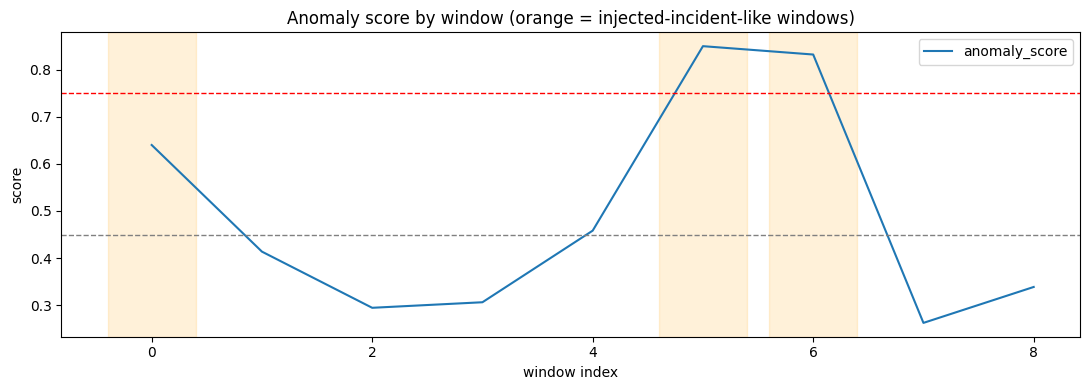

In [2]:
metrics = train_anomaly_model(windows)
bundle = load_anomaly_bundle()
results = [score_window(w, bundle) for w in windows]
score_df = pd.DataFrame(results)
score_df['incident_like'] = window_df['incident_like'].to_numpy()
score_df['window_start'] = window_df['window_start'].to_numpy()

# Detection view with incident annotations.
plt.figure(figsize=(11, 4))
plt.plot(score_df['anomaly_score'].to_numpy(), label='anomaly_score')
for idx, flagged in enumerate(score_df['incident_like'].to_numpy()):
    if flagged:
        plt.axvspan(idx - 0.4, idx + 0.4, color='orange', alpha=0.15)
plt.axhline(0.45, color='gray', linestyle='--', linewidth=1)
plt.axhline(0.75, color='red', linestyle='--', linewidth=1)
plt.title('Anomaly score by window (orange = injected-incident-like windows)')
plt.xlabel('window index')
plt.ylabel('score')
plt.legend()
plt.tight_layout()

metrics

In [3]:
# Explain false alerts (alerts outside incident-like windows).
joined = window_df.reset_index(drop=True).copy()
joined['anomaly_score'] = score_df['anomaly_score'].to_numpy()
joined['anomaly_label'] = score_df['anomaly_label'].to_numpy()
joined['reason_tags'] = score_df['reason_tags'].to_numpy()

alert_df = joined[joined['anomaly_label'].isin(['Unusual', 'Likely Compromise'])]
false_alerts = alert_df[~alert_df['incident_like'].astype(bool)].copy()

explanations = []
for _, row in false_alerts.head(10).iterrows():
    text = explain_anomaly_result(
        anomaly_score=float(row['anomaly_score']),
        reason_tags=row['reason_tags'] if isinstance(row['reason_tags'], list) else [],
        queries_per_min=float(row['queries_per_min']),
        nxdomain_rate=float(row['nxdomain_rate']),
    )
    explanations.append(
        {
            'window_start': row['window_start'],
            'anomaly_label': row['anomaly_label'],
            'anomaly_score': float(row['anomaly_score']),
            'nxdomain_rate': float(row['nxdomain_rate']),
            'summary': text['summary'],
        }
    )

print('Alert windows:', len(alert_df), '| False-alert-like windows:', len(false_alerts))
pd.DataFrame(explanations)

Alert windows: 4 | False-alert-like windows: 1


,window_start,anomaly_label,anomaly_score,nxdomain_rate,summary
0,2026-02-17T20:17:17+00:00,Unusual,0.458253,0.031746,This window has unusual DNS behavior that may ...
